In [1]:
#Import Libraries

#for reading and data-manipulation
import os
import numpy as np
import pandas as pd

In [2]:
#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [3]:
#for data preprocessing
import time
from contractions import contractions_dict
import re
from collections import Counter
from wordcloud import STOPWORDS
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# for ML model Implementation
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from bertopic import BERTopic
from sklearn.metrics import silhouette_score
import hdbscan
from sentence_transformers import SentenceTransformer
from umap import UMAP

/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# This code avoids printing different warnings in following jupyter cells.
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=SettingWithCopyWarning)


In [6]:
df = pd.read_csv('lenovoK8.csv', encoding='ISO-8859-1') # this is for the LenovoK8 dataset.
df.head()

,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...
3,1,Good
4,0,The worst phone everThey have changed the last...


In [7]:
df = df.rename(columns={'review': 'brief_review'})


In [8]:

df = df[['brief_review', 'sentiment']].dropna()


In [9]:
# df = df_filtered.rename(columns={'article_id': 'unique_identifier', 'content': 'brief_review'})

In [10]:
# df = df[['unique_identifier', 'brief_review', 'category']].dropna()

In [11]:
# Handling missing values
df.isnull().sum()

brief_review    0
sentiment       0
dtype: int64

In [12]:
#handling duplicate values 
len(df[df.duplicated(subset=['brief_review'])])

1708

In [13]:
# Drop duplicate 
df_cleaned = df.drop_duplicates(subset = ["brief_review"])
print(df_cleaned.head())

                                        brief_review  sentiment
0             Good but need updates and improvements          1
1  Worst mobile i have bought ever, Battery is dr...          0
2  when I will get my 10% cash back.... its alrea...          1
3                                               Good          1
4  The worst phone everThey have changed the last...          0


In [14]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12967 entries, 0 to 14674
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brief_review  12967 non-null  object
 1   sentiment     12967 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 303.9+ KB


In [15]:
# Expand Contraction

# Function to expand contractions using the contractions_dict
def expand_contractions(text):
    # Regular expression pattern to match contractions
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        expanded = contractions_dict.get(match.lower())
        return expanded

    expanded_text = contractions_pattern.sub(expand_match, text)
    return expanded_text

# Apply the expand_contractions function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(expand_contractions)

In [16]:
# Remove Punctuations

# Function to remove punctuations from text
def remove_punctuations(text):
    # Create a translation table to remove punctuations
    translator = str.maketrans('', '', string.punctuation +'\n')

    # Apply the translation table to remove punctuations
    text_without_punctuations = text.translate(translator)
    return text_without_punctuations

# Apply the remove_punctuations function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_punctuations)

In [17]:
# Convert text in the "brief_review" column to lowercase
df_cleaned['brief_review'] = df_cleaned['brief_review'].str.lower()

In [18]:
# Function to remove URLs from text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return re.sub(url_pattern, '', text)

# Function to remove words containing digits from text
def remove_words_with_digits(text):
    return ' '.join(word for word in text.split() if not any(char.isdigit() for char in word))

# Function to remove non-ASCII characters (special characters)
def remove_special_characters(text):
    # Replace non-ASCII characters with a space
    return re.sub(r'[^\x00-\x7F]+', ' ', text)

# Apply the remove_urls function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_urls)

# Apply the remove_words_with_digits function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_words_with_digits)

# Apply the remove_special_characters function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_special_characters)

# Verify the cleaned data
df_cleaned['brief_review'].head()


0               good but need updates and improvements
1    worst mobile i have bought ever battery is dra...
2         when i will get my cash back its already ary
3                                                 good
4    the worst phone everthey have changed the last...
Name: brief_review, dtype: object

In [19]:
 # Remove Stopwords
# Download the list of stopwords if not already downloaded
nltk.download('stopwords')

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Add unnecessary words to the list of English stopwords
stop_unnecessary_words = stop_words.union(set(['mr', 'people', 'would', 'year', 'said', 'say', 'also', 'wale', 'could']))


# Function to remove stopwords from text
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if len(word)>2]
    filtered_words = [word for word in words if word.lower() not in stop_unnecessary_words]
    return ' '.join(filtered_words)

# Apply the remove_stopwords function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/binitkc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Remove white spaces from the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].str.replace('\s+', ' ', regex=True)

In [21]:
# Tokenization

# Download the punkt package
nltk.download('punkt')
# Download the punkt_tab resource as well
nltk.download('punkt_tab')

# Function to tokenize text
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Apply the tokenize_text function to the "brief_review" column
df_cleaned['tokenized_content'] = df_cleaned['brief_review'].apply(tokenize_text)


[nltk_data] Downloading package punkt to /Users/binitkc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/binitkc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [22]:
df_cleaned.head()

,brief_review,sentiment,tokenized_content
0,good need updates improvements,1,"[good, need, updates, improvements]"
1,worst mobile bought ever battery draining like...,0,"[worst, mobile, bought, ever, battery, drainin..."
2,get cash back already ary,1,"[get, cash, back, already, ary]"
3,good,1,[good]
4,worst phone everthey changed last phone proble...,0,"[worst, phone, everthey, changed, last, phone,..."


In [23]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to perform stemming on text
def stem_text(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Apply the stem_text function to the "tokenized_content" column
df_cleaned['stemmed_content'] = df_cleaned['tokenized_content'].apply(stem_text)

In [24]:
nltk.download('wordnet')
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to perform lemmatization on text
def lemmatize_text(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Apply the lemmatize_text function to the "tokenized_content" column
df_cleaned['lemmatized_content'] = df_cleaned['tokenized_content'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /Users/binitkc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
df_cleaned['lemmatized_content'].info()

<class 'pandas.core.series.Series'>
Index: 12967 entries, 0 to 14674
Series name: lemmatized_content
Non-Null Count  Dtype 
--------------  ----- 
12967 non-null  object
dtypes: object(1)
memory usage: 202.6+ KB


In [26]:
df_cleaned = df_cleaned.iloc[0:10000]

In [27]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 11237
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   brief_review        10000 non-null  object
 1   sentiment           10000 non-null  int64 
 2   tokenized_content   10000 non-null  object
 3   stemmed_content     10000 non-null  object
 4   lemmatized_content  10000 non-null  object
dtypes: int64(1), object(4)
memory usage: 468.8+ KB


In [28]:
# ML Model - 1 Implementation

# Convert the list of lemmatized tokens into a list of lists
lemmatized_text = [tokens for tokens in df_cleaned['lemmatized_content']]

# Create a dictionary of terms with term frequency filtering
dictionary = corpora.Dictionary(lemmatized_text)
dictionary.filter_extremes(no_below=3, no_above=0.85)

# Fit the Algorithm

# Create a Gensim corpus
corpus_gensim = [dictionary.doc2bow(text) for text in lemmatized_text]

# Build LDA model
num_topics = 5
lda_model = LdaModel(corpus_gensim, num_topics=num_topics, id2word=dictionary, passes=20, random_state= 40)

print('\n')
print('\n')
# Calculate coherence score
coherence_model = CoherenceModel(model=lda_model, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Print coherence score
print(f"Coherence Score: {coherence_score:.4f}")


# Print topics and associated words
for topic_id, topic_words in lda_model.print_topics():
    print('\n')
    print(f"Topic {topic_id}: {topic_words}")

/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Coherence Score: 0.5570


Topic 0: 0.063*"battery" + 0.033*"phone" + 0.026*"charging" + 0.019*"day" + 0.019*"product" + 0.017*"charge" + 0.016*"get" + 0.016*"hour" + 0.016*"fast" + 0.016*"time"


Topic 1: 0.042*"phone" + 0.026*"working" + 0.019*"call" + 0.018*"buy" + 0.018*"worst" + 0.013*"amazon" + 0.013*"network" + 0.013*"mobile" + 0.012*"product" + 0.012*"service"


Topic 2: 0.075*"good" + 0.074*"camera" + 0.039*"phone" + 0.032*"quality" + 0.030*"battery" + 0.019*"performance" + 0.012*"better" + 0.012*"note" + 0.010*"sound" + 0.010*"backup"


Topic 3: 0.048*"problem" + 0.043*"phone" + 0.041*"heating" + 0.032*"issue" + 0.031*"good" + 0.027*"money" + 0.024*"mobile" + 0.016*"screen" + 0.015*"waste" + 0.012*"like"


Topic 4: 0.087*"phone" + 0.065*"good" + 0.065*"product" + 0.065*"mobile" + 0.061*"nice" + 0.045*"best" + 0.043*"price" + 0.023*"awesome" + 0.018*"excellent" + 0.016*"great"


In [29]:
# import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import ParameterGrid
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel

# Define a grid of hyperparameters to search over
param_grid = {
    'num_topics': [3, 4, 5, 6, 7, 8],
    'passes': [10,15,20,25]
}

best_coherence_score = -1
best_lda_model = None
scores = []  # To store coherence scores
topics = []  # To store number of topics
passes_list = []  # To store passes for each model

# Perform grid search
for params in ParameterGrid(param_grid):
    lda_model = LdaModel(corpus=corpus_gensim, id2word=dictionary, **params)
    coherence_model = CoherenceModel(model=lda_model, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # Track best model
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_lda_model = lda_model
    
    # Collect data for plotting
    scores.append(coherence_score)
    topics.append(params['num_topics'])
    passes_list.append(params['passes'])


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

In [30]:
# After grid search is completed and best_lda_model is chosen:
best_lda_model.save("Trained_models/lda_news.model")

# Optionally, print confirmation
print(" LDA_news model saved successfully! ")

 LDA_news model saved successfully! 


In [31]:
# Load the saved model
best_lda_model = LdaModel.load("Trained_models/lda_news.model")

# Optionally, print to confirm successful loading
print("LDA model loaded successfully!")

LDA model loaded successfully!


In [ ]:
# Plot coherence score in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(topics, passes_list, scores, c=scores, cmap='viridis', marker='o')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Passes')
ax.set_zlabel('Coherence Score')
ax.set_title("Coherence Score for Different Hyperparameter Combinations")
plt.show()

# Print best hyperparameters and coherence score
print("Best Hyperparameters:", best_lda_model)
print(f"Best Coherence Score: {best_coherence_score:.4f}")

# Print topics and associated words for the best model
for topic_id, topic_words in best_lda_model.print_topics():
    print(f"\nTopic {topic_id}: {topic_words}")

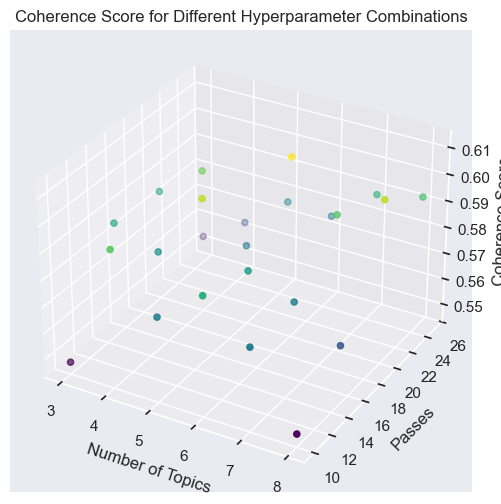

Best Number of Topics: 6
Best Number of Passes: 20
Best Coherence Score: 0.6117

Topic 0: 0.058*"mobile" + 0.037*"bad" + 0.026*"network" + 0.025*"phone" + 0.025*"call" + 0.023*"buy" + 0.023*"problem" + 0.020*"note" + 0.018*"issue" + 0.016*"waste"

Topic 1: 0.146*"good" + 0.098*"phone" + 0.053*"nice" + 0.048*"product" + 0.042*"price" + 0.041*"best" + 0.040*"mobile" + 0.029*"awesome" + 0.025*"camera" + 0.019*"performance"

Topic 2: 0.038*"update" + 0.023*"screen" + 0.019*"software" + 0.018*"option" + 0.018*"working" + 0.016*"need" + 0.016*"not" + 0.016*"can" + 0.016*"cast" + 0.015*"phone"

Topic 3: 0.100*"battery" + 0.037*"charging" + 0.030*"heating" + 0.030*"phone" + 0.022*"fast" + 0.021*"problem" + 0.021*"issue" + 0.020*"charge" + 0.020*"hour" + 0.019*"heat"

Topic 4: 0.077*"camera" + 0.057*"good" + 0.035*"quality" + 0.027*"phone" + 0.020*"battery" + 0.016*"note" + 0.013*"sound" + 0.012*"dual" + 0.012*"better" + 0.010*"front"

Topic 5: 0.062*"phone" + 0.022*"product" + 0.020*"buy" + 0.

In [32]:
# Plot coherence score in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(topics, passes_list, scores, c=scores, cmap='viridis', marker='o')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Passes')
ax.set_zlabel('Coherence Score')
ax.set_title("Coherence Score for Different Hyperparameter Combinations")
plt.show()

# Find the best hyperparameters and coherence score
best_index = scores.index(max(scores))  # Get the index of the best score
best_topics = topics[best_index]
best_passes = passes_list[best_index]
best_coherence_score = scores[best_index]

# Print best hyperparameters and coherence score
print("Best Number of Topics:", best_topics)
print("Best Number of Passes:", best_passes)
print(f"Best Coherence Score: {best_coherence_score:.4f}")

# Print topics and associated words for the best model
for topic_id, topic_words in best_lda_model.print_topics():
    print(f"\nTopic {topic_id}: {topic_words}")


In [34]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_topic_diversity(lda_model, num_topics):
    # Get the topic-word distributions from the LDA model
    topic_word_distributions = [lda_model.get_topics()[i] for i in range(num_topics)]
    
    # Calculate pairwise cosine similarities between topics
    similarities = cosine_similarity(topic_word_distributions)
    
    # Set diagonal elements to zero (similarity of a topic with itself should not be counted)
    np.fill_diagonal(similarities, 0)
    
    # Calculate topic diversity (1 - average cosine similarity)
    avg_similarity = np.mean(similarities)
    topic_diversity = 1 - avg_similarity
    
    return topic_diversity

# Assuming 'best_lda_model' is the trained model and 'num_topics' is the number of topics
topic_diversity = calculate_topic_diversity(best_lda_model, best_lda_model.num_topics)

print(f"Topic Diversity: {topic_diversity:.4f}")


Topic Diversity: 0.7862


In [37]:
lda_model = best_lda_model

In [38]:
# Visualize the topics
vis_data = gensimvis.prepare(lda_model, corpus_gensim, dictionary)
pyLDAvis.display(vis_data)

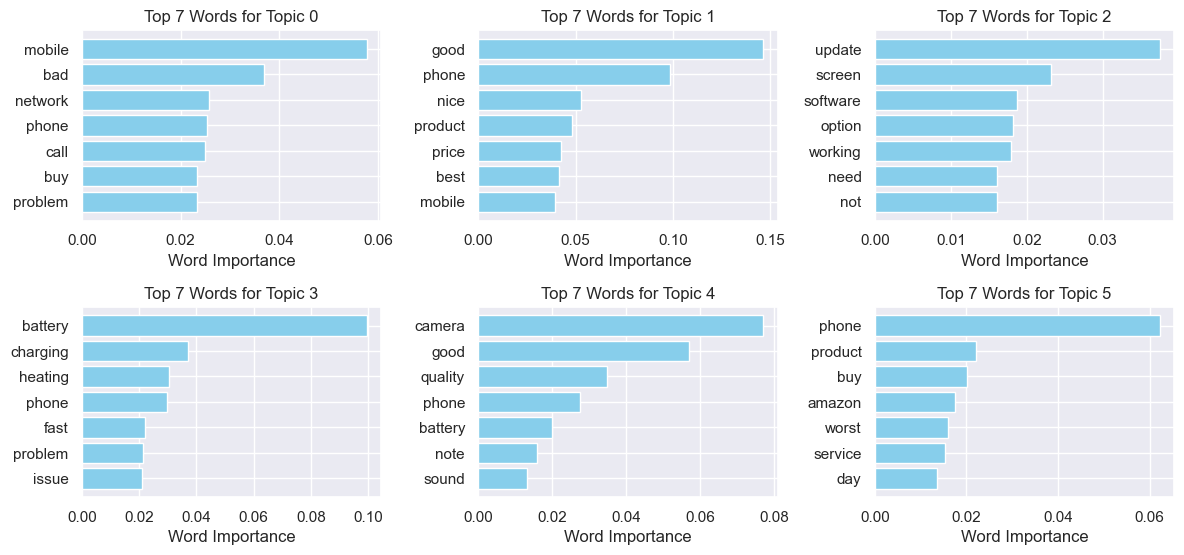

In [42]:
# import matplotlib.pyplot as plt

# Parameters
num_top_words = 7  # Number of top words to display for each topic
num_topics = lda_model.num_topics  # Total number of topics in the LDA model

# Define grid size for plotting (adjust based on the number of topics)
num_rows = 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Plot the top words for each topic
for topic_idx in range(num_topics):
    row = topic_idx // num_cols
    col = topic_idx % num_cols

    # Get the top words and weights for the current topic
    top_words = lda_model.show_topic(topic_idx, topn=num_top_words)
    words, weights = zip(*top_words)

    # Plot horizontal bar chart for the topic
    axes[row, col].barh(words, weights, color='skyblue')
    axes[row, col].set_title(f"Top {num_top_words} Words for Topic {topic_idx}")
    axes[row, col].set_xlabel("Word Importance")
    axes[row, col].invert_yaxis()  # Show the most important word at the top

# Remove empty subplots if the grid is larger than the number of topics
for i in range(num_topics, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


In [31]:
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
# import numpy as np

# Step 1: Prepare text data
# Assuming 'lemmatized_text' is a list of lists of lemmatized tokens as per your previous code
lemmatized_text = [tokens for tokens in df_cleaned['lemmatized_content']]

# Step 2: Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_text)

# Step 3: Train LSA model using TruncatedSVD
num_topics = 5
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

# Step 4: Extract top words for each topic
def get_lsa_topics(model, vectorizer, n_words=10):
    topics = []
    for idx, topic in enumerate(model.components_):
        top_words_indices = topic.argsort()[:-n_words - 1:-1]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_indices]
        topics.append(top_words)
    return topics

topics = get_lsa_topics(lsa_model, tfidf_vectorizer)

# Step 5: Create a Gensim dictionary and corpus for coherence calculation
dictionary = Dictionary(lemmatized_text)
corpus = [dictionary.doc2bow(text) for text in lemmatized_text]

# Step 6: Calculate the coherence score
coherence_model = CoherenceModel(topics=topics, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Print coherence score
print(f"Coherence Score: {coherence_score:.4f}")

# Display the topics and their associated words
for i, topic in enumerate(topics):
    print(f"Topic {i}: {', '.join(topic)}")


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Coherence Score: 0.4435
Topic 0: good, phone, camera, battery, product, mobile, nice, quality, price, best
Topic 1: good, overall, condition, mobil, expected, expectedperformance, supplier, curiour, worthfull, issueperformance
Topic 2: nice, product, good, feature, happy, handset, price, delivery, excellent, really
Topic 3: phone, best, price, good, range, budget, great, feature, amazing, awesome
Topic 4: product, phone, worst, price, buy, best, bad, excellent, amazon, awesome


In [32]:

# Step 1: Prepare text data
lemmatized_text = [tokens for tokens in df_cleaned['lemmatized_content']]

# Step 2: Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_text)

# Function to extract top words for each topic
def get_lsa_topics(model, vectorizer, n_words=10):
    topics = []
    for idx, topic in enumerate(model.components_):
        top_words_indices = topic.argsort()[:-n_words - 1:-1]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_indices]
        topics.append(top_words)
    return topics

# Step 3: Hyperparameter tuning
topic_range = [2, 3, 5, 6, 7, 10, 15]  # Range of topic numbers to evaluate
best_coherence_score = -1
best_num_topics = None
best_lsa_model = None
best_topics = None

# Create a Gensim dictionary and corpus
dictionary = Dictionary(lemmatized_text)
corpus = [dictionary.doc2bow(text) for text in lemmatized_text]

for num_topics in topic_range:
    # Train LSA model
    lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
    lsa_model.fit(tfidf_matrix)
    
    # Extract topics
    topics = get_lsa_topics(lsa_model, tfidf_vectorizer)
    
    # Calculate coherence score
    coherence_model = CoherenceModel(topics=topics, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")
    
    # Update the best model if the coherence score improves
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_num_topics = num_topics
        best_lsa_model = lsa_model
        best_topics = topics

# Display the best coherence score and the corresponding number of topics
print(f"\nBest Coherence Score: {best_coherence_score:.4f} with {best_num_topics} topics")

# Display the topics and their associated words for the best model
print("\nBest Topics:")
for i, topic in enumerate(best_topics):
    print(f"Topic {i}: {', '.join(topic)}")


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 2, Coherence Score: 0.4506


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 3, Coherence Score: 0.4443


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 5, Coherence Score: 0.4435


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 6, Coherence Score: 0.4499


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 7, Coherence Score: 0.4661


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 10, Coherence Score: 0.4548


/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with

Number of Topics: 15, Coherence Score: 0.4382

Best Coherence Score: 0.4661 with 7 topics

Best Topics:
Topic 0: good, phone, camera, battery, product, mobile, nice, quality, price, best
Topic 1: good, overall, condition, mobil, expected, expectedperformance, supplier, curiour, worthfull, issueperformance
Topic 2: nice, product, good, price, feature, happy, handset, delivery, really, excellent
Topic 3: phone, best, price, good, range, budget, great, feature, awesome, amazing
Topic 4: product, phone, price, best, worst, buy, bad, excellent, amazon, money
Topic 5: mobile, best, product, price, range, awesome, excellent, ever, buy, note
Topic 6: camera, best, quality, battery, poor, performance, price, backup, bad, awesome


In [33]:
def calculate_topic_diversity(topics, top_n_words=10):
    """
    Calculates topic diversity as the proportion of unique words 
    in the top N words across all topics.
    """
    unique_words = set()
    total_words = 0

    for topic in topics:
        top_words = topic[:top_n_words]
        unique_words.update(top_words)
        total_words += len(top_words)

    topic_diversity = len(unique_words) / total_words
    return topic_diversity

# Calculate topic diversity for the best LSA model
topic_diversity_score = calculate_topic_diversity(best_topics, top_n_words=10)
print(f"\nTopic Diversity: {topic_diversity_score:.4f}")



Topic Diversity: 0.5714
